## Analysis on 2011_09_26_0035

This notebook analysis the comparison between Extended Kalman Filter (EKF) and Unscented Kalman Filter (UKF) on kitti dataset found on (link)

### Import libraries

In [1]:
import numpy as np
import pykitti
import sys
import matplotlib.pyplot as plt

from read_kitti_data import LoadKittiData
from ExtendedKalmanFilter import ExtendedKalmanFilter
from UnscentedKalmanFilter import UnscentedKalmanFilter
from filter_estimation import Filter_Estimation, apply_estimation_filter
from helper_functions import lla_to_enu, normalize_angles

%matplotlib inline
np.random.seed(10)

### Read file

In [2]:
kitti_root_dir = '../data/kitti'
kitti_date = '2011_09_26'
kitti_drive = '0035'
kitti_data = LoadKittiData(kitti_root_dir, kitti_date, kitti_drive)

## Case 1: low noise

### Defining noises 

In [3]:
obs_noise_std=[5, 5, np.pi]
input_noise_std=[0.3, 0.02]

In [4]:
kitti_data.add_gaussian_noise_observation(obs_noise_std)
kitti_data.add_gaussian_noise_control_input(input_noise_std)

### Plot control input data

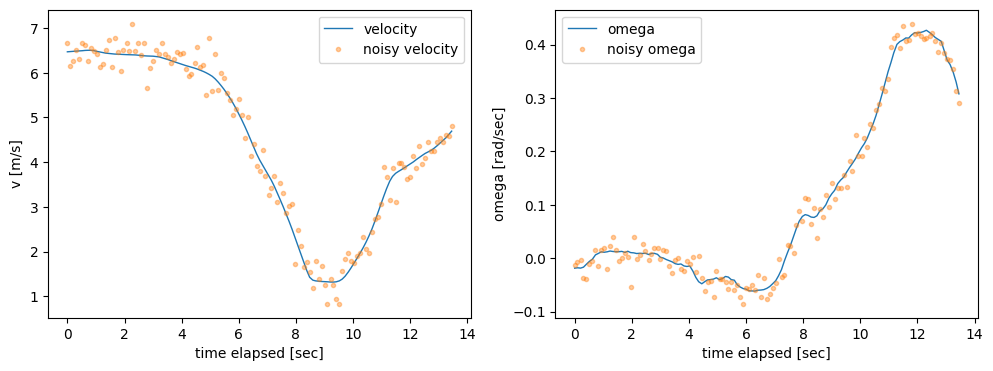

In [5]:
kitti_data.plot_control_input_data()

### Plot observation data

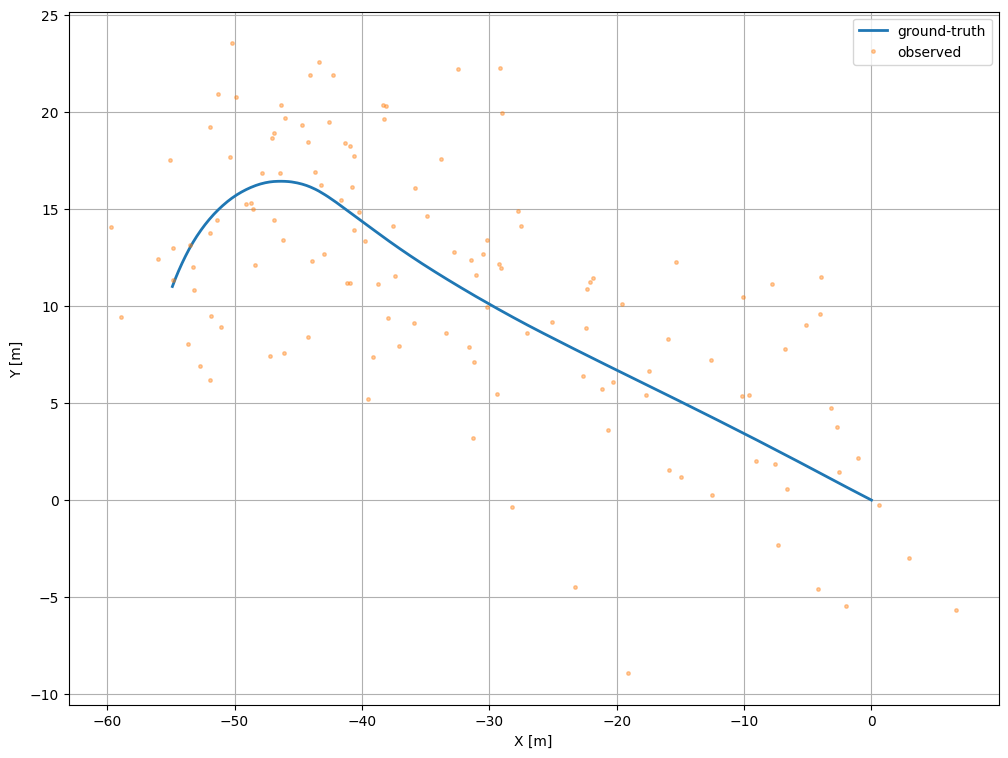

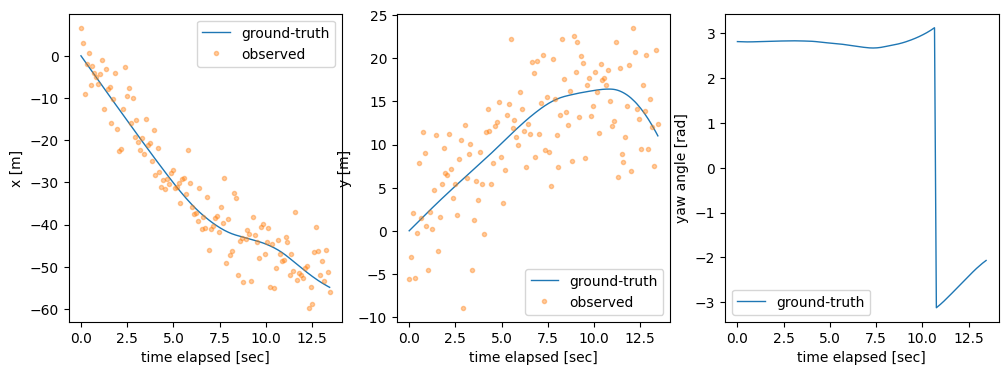

In [6]:
kitti_data.plot_observation_data()

### Initialising state and covariance

In [7]:
# initial state x_0
initial_theta_std = np.pi
initial_theta = normalize_angles(np.random.normal(0, initial_theta_std))

x_0 = np.array([
    kitti_data.observation_states[0, 0],
    kitti_data.observation_states[1, 0],
    initial_theta
])
x_0

array([ 6.65793252, -5.64775597, -1.54725783])

In [8]:
# covariance for initial state estimation error (Sigma_0)
P_0 = np.array([
    [obs_noise_std[0] ** 2., 0., 0.],
    [0., obs_noise_std[1] ** 2., 0.],
    [0., 0., obs_noise_std[2] ** 2.]
])
P_0

array([[25.       ,  0.       ,  0.       ],
       [ 0.       , 25.       ,  0.       ],
       [ 0.       ,  0.       ,  9.8696044]])

In [9]:
# measurement error covariance Q
Q = np.array([
    [obs_noise_std[0] ** 2., 0.],
    [0., obs_noise_std[1] ** 2.]
])
Q

array([[25.,  0.],
       [ 0., 25.]])

In [10]:
# 
R = np.array([
    [input_noise_std[0] ** 2., 0., 0.],
    [0., input_noise_std[0] ** 2., 0.],
    [0., 0., input_noise_std[1] ** 2.]
])
R

array([[0.09  , 0.    , 0.    ],
       [0.    , 0.09  , 0.    ],
       [0.    , 0.    , 0.0004]])

### Extended Kalman Filter

In [11]:
ekf_estimated_state = apply_estimation_filter(kitti_data, 'EKF', x_0, P_0, R, Q)

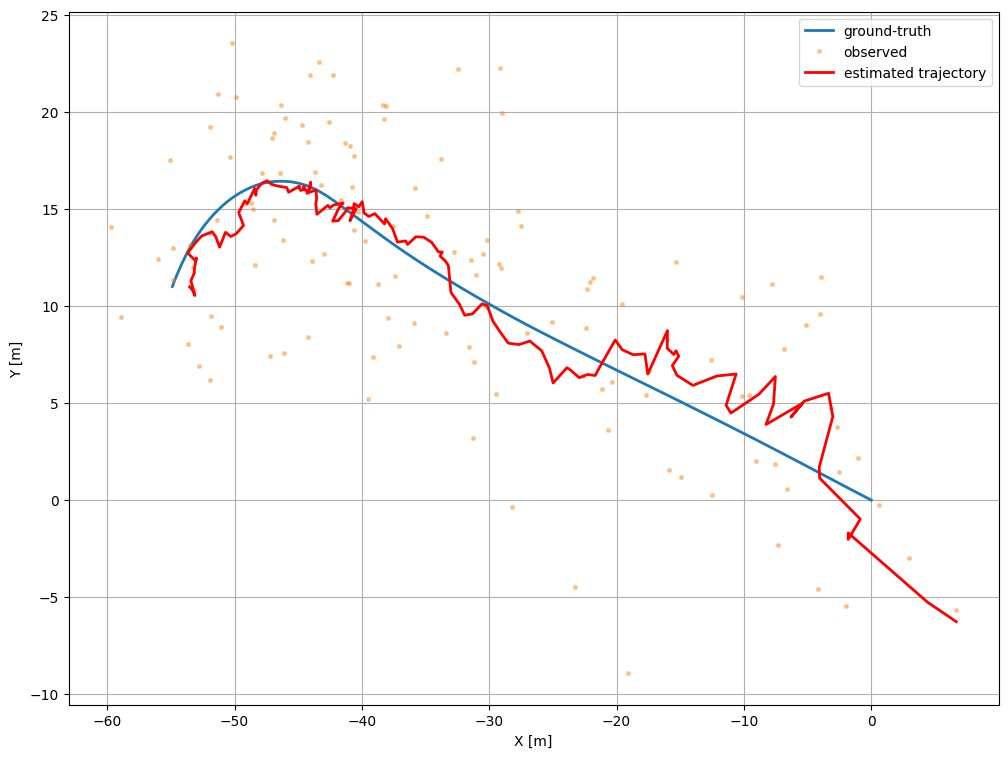

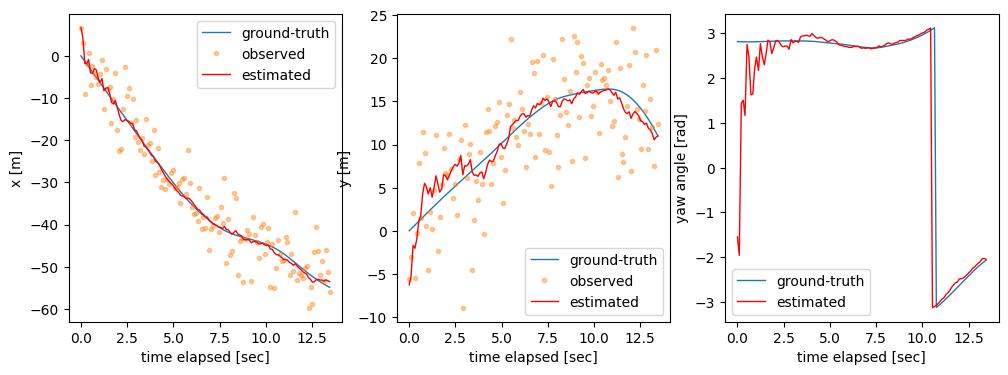

In [12]:
kitti_data.plot_estimated_data(ekf_estimated_state)

In [13]:
kitti_data.evaluate_filter(ekf_estimated_state)

{'RMSE': array([1.03799619, 1.49080974, 0.36187222]),
 'MAE': array([0.67845616, 1.10103004, 0.15543523]),
 'MSE': array([1.07743609, 2.22251367, 0.1309515 ]),
 'NRMSE': array([0.01455676, 0.02090697, 0.00507486]),
 'Mean_Error': array([0.0371292 , 0.02544827, 0.01967341]),
 'Std_Error': array([1.03733192, 1.49059252, 0.36133704]),
 'Mean_Angular_Error': 0.01967341486760585}

### Unscented Kalman Filter

In [14]:
ukf_estimated_state = apply_estimation_filter(kitti_data, 'UKF', x_0, P_0, R, Q)

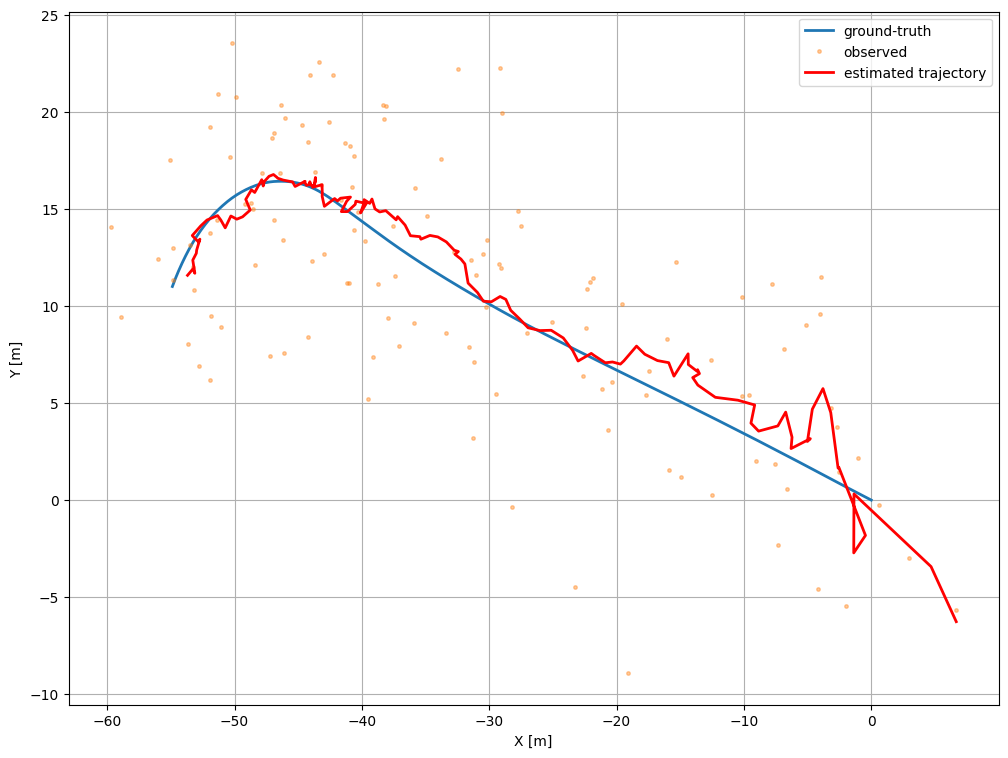

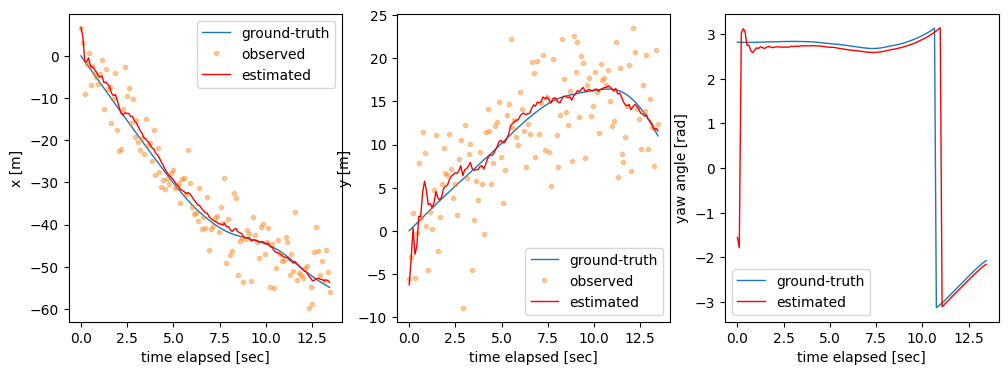

In [15]:
kitti_data.plot_estimated_data(ukf_estimated_state)

In [16]:
kitti_data.evaluate_filter(ukf_estimated_state)

{'RMSE': array([1.40099891, 1.11429391, 0.24534556]),
 'MAE': array([1.0655092 , 0.70517029, 0.12376195]),
 'MSE': array([1.96279795, 1.24165091, 0.06019444]),
 'NRMSE': array([0.01964747, 0.01562675, 0.0034407 ]),
 'Mean_Error': array([-0.90343579, -0.18518529,  0.05726095]),
 'Std_Error': array([1.0707949 , 1.09879813, 0.23856996]),
 'Mean_Angular_Error': 0.05726094526846917}

### Compare yaw angle

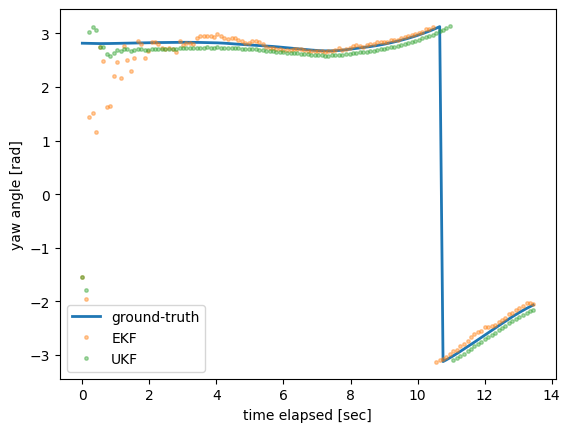

In [17]:
timestamps = kitti_data.timestamps
original_yaw_angle = kitti_data.ground_truth_states[2, :]
ekf_estimated = ekf_estimated_state[2, :]
ukf_estimated = ukf_estimated_state[2, :]

fig = plt.figure()
plt.plot(timestamps, original_yaw_angle, lw=2, label="ground-truth")
plt.plot(timestamps, ekf_estimated, marker='.', lw=0, markersize=5, alpha=0.4, label='EKF')
plt.plot(timestamps, ukf_estimated, marker='.', lw=0, markersize=5, alpha=0.4, label='UKF')
plt.xlabel('time elapsed [sec]')
plt.ylabel('yaw angle [rad]')
plt.legend()
plt.savefig('2011_09_26_0035_01.png', bbox_inches='tight')
#plt.show()

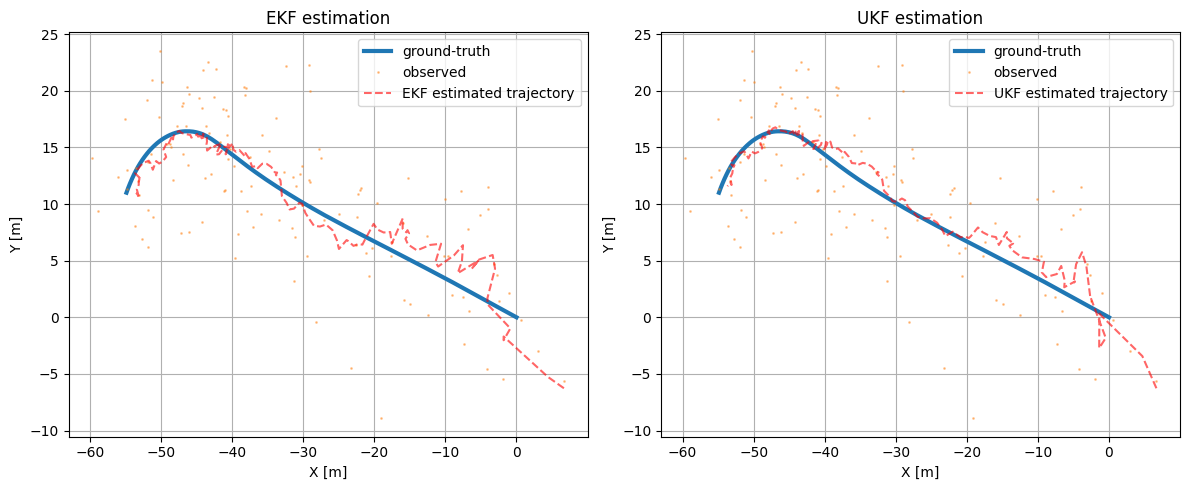

In [18]:
fig, axarr = plt.subplots(1, 2, figsize=(12,5))
ax = axarr[0]
ax.plot(kitti_data.ground_truth_states[0, :], kitti_data.ground_truth_states[1, :], lw=3, label='ground-truth')
ax.plot(kitti_data.observation_states[0, :], kitti_data.observation_states[1, :], lw=0, marker='.', markersize=2, alpha=0.4, label='observed')
ax.plot(ekf_estimated_state[0, :], ekf_estimated_state[1, :], linestyle='dashed', lw=1.5, alpha=0.6, label='EKF estimated trajectory', color='r')
#ax.plot(ukf_estimated_state[0, :], ukf_estimated_state[1, :], linestyle='dashed', lw=1.5, alpha=0.99, label='UKF estimated trajectory', color='g')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
#ax.set_ylim([-70, 55])
#ax.set_xlim([-350, 180])
ax.title.set_text('EKF estimation')
ax.grid()
ax.legend()

ax = axarr[1]
ax.plot(kitti_data.ground_truth_states[0, :], kitti_data.ground_truth_states[1, :], lw=3, label='ground-truth')
ax.plot(kitti_data.observation_states[0, :], kitti_data.observation_states[1, :], lw=0, marker='.', markersize=2, alpha=0.4, label='observed')
#ax.plot(ekf_estimated_state[0, :], ekf_estimated_state[1, :], linestyle='dashed', lw=1.5, alpha=0.99, label='EKF estimated trajectory', color='r')
ax.plot(ukf_estimated_state[0, :], ukf_estimated_state[1, :], linestyle='dashed', lw=1.5, alpha=0.6, label='UKF estimated trajectory', color='r')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
#ax.set_ylim([-70, 55])
#ax.set_xlim([-350, 180])
ax.title.set_text('UKF estimation')
ax.grid()
ax.legend()

plt.tight_layout()
#plt.show()
plt.savefig('2011_09_26_0035.png', bbox_inches='tight')

## Case 2: high noise

### Defining noises

In [19]:
obs_noise_std=[15, 15, np.pi]
input_noise_std=[0.9, 0.06]

In [20]:
kitti_data.add_gaussian_noise_observation(obs_noise_std)
kitti_data.add_gaussian_noise_control_input(input_noise_std)

### Plot control input data

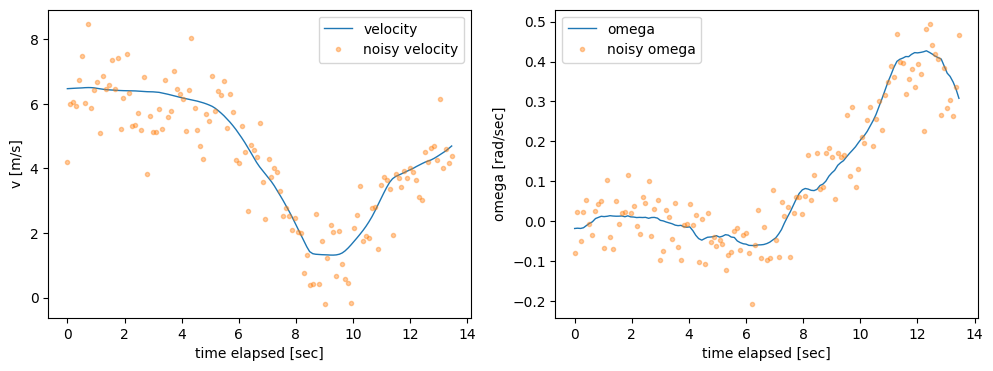

In [21]:
kitti_data.plot_control_input_data()

### Plot observation data

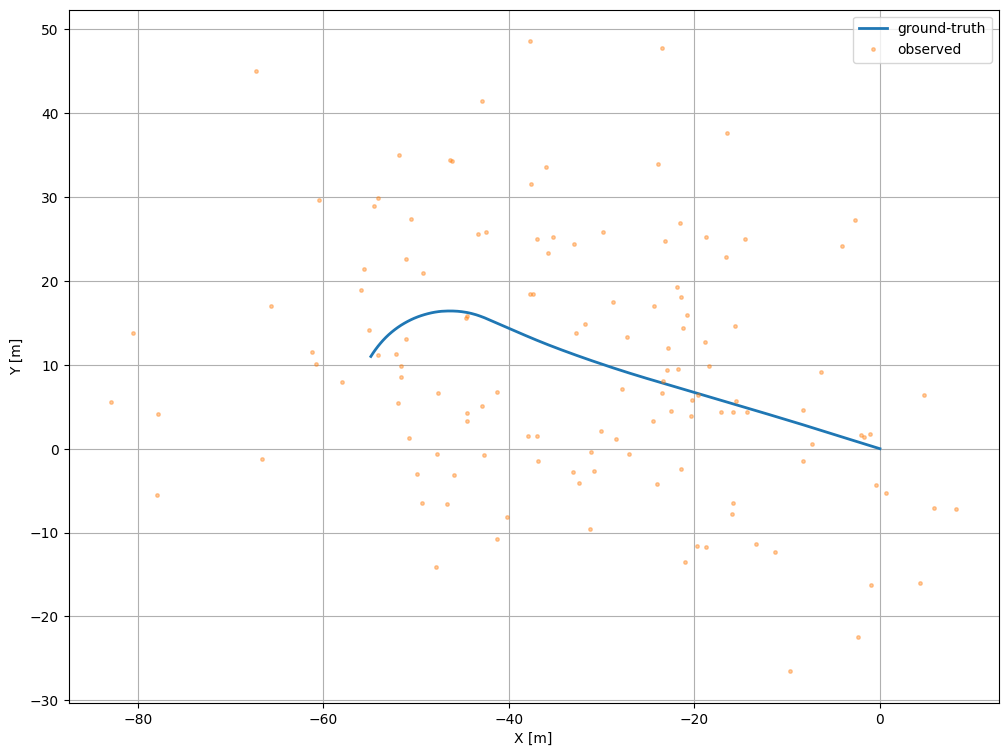

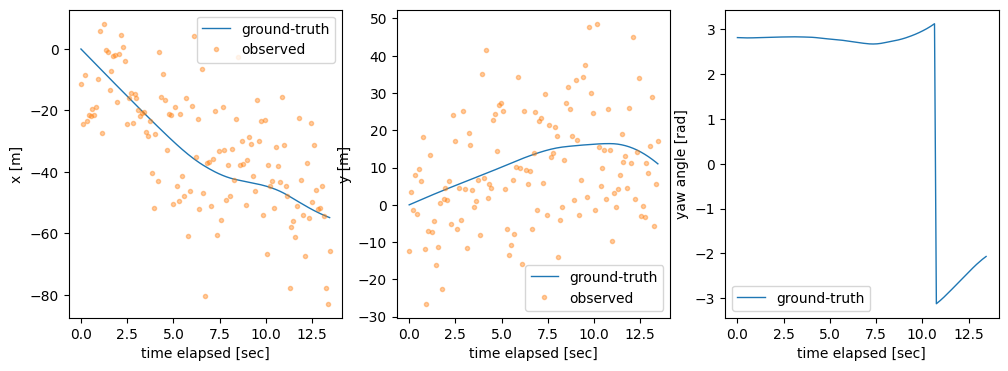

In [22]:
kitti_data.plot_observation_data()

### Initialise state and covariance

In [23]:
# initial state x_0
initial_theta_std = np.pi
initial_theta = normalize_angles(np.random.normal(0, initial_theta_std))

x_0 = np.array([
    kitti_data.observation_states[0, 0],
    kitti_data.observation_states[1, 0],
    initial_theta
])
x_0

array([-11.27430661, -12.26904564,  -1.52342037])

In [24]:
# covariance for initial state estimation error (Sigma_0)
P_0 = np.array([
    [obs_noise_std[0] ** 2., 0., 0.],
    [0., obs_noise_std[1] ** 2., 0.],
    [0., 0., obs_noise_std[2] ** 2.]
])
P_0

array([[225.       ,   0.       ,   0.       ],
       [  0.       , 225.       ,   0.       ],
       [  0.       ,   0.       ,   9.8696044]])

In [25]:
# measurement error covariance Q
Q = np.array([
    [obs_noise_std[0] ** 2., 0.],
    [0., obs_noise_std[1] ** 2.]
])
Q

array([[225.,   0.],
       [  0., 225.]])

In [26]:
#
R = np.array([
    [input_noise_std[0] ** 2., 0., 0.],
    [0., input_noise_std[0] ** 2., 0.],
    [0., 0., input_noise_std[1] ** 2.]
])
R

array([[0.81  , 0.    , 0.    ],
       [0.    , 0.81  , 0.    ],
       [0.    , 0.    , 0.0036]])

### Extended Kalman Filter

In [27]:
ekf_estimated_state = apply_estimation_filter(kitti_data, 'EKF', x_0, P_0, R, Q)

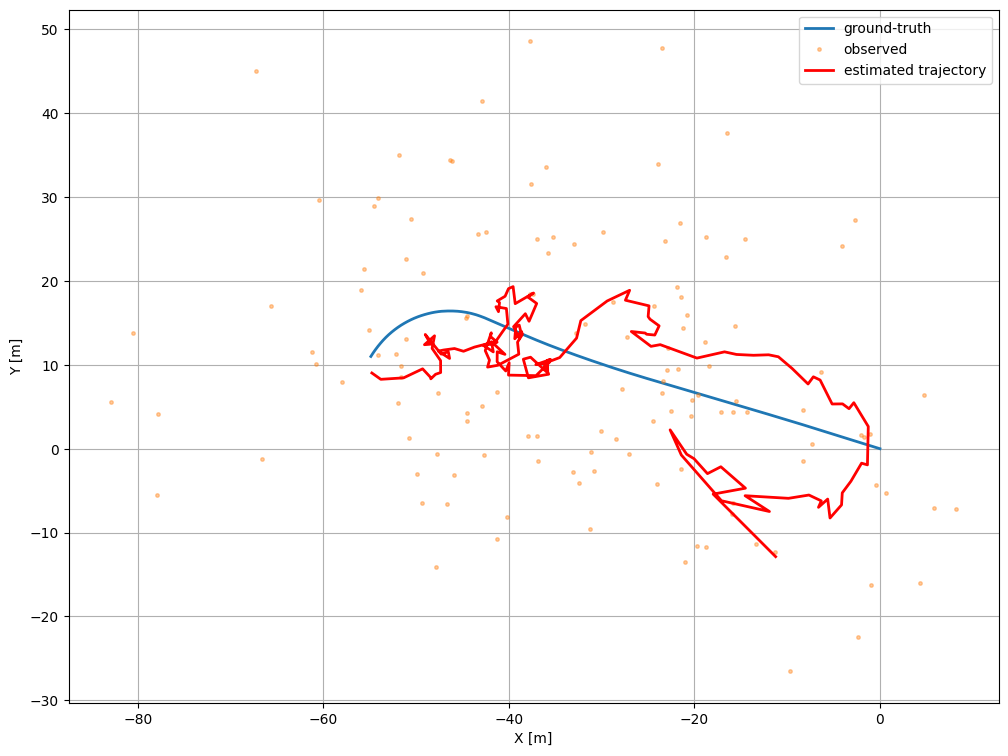

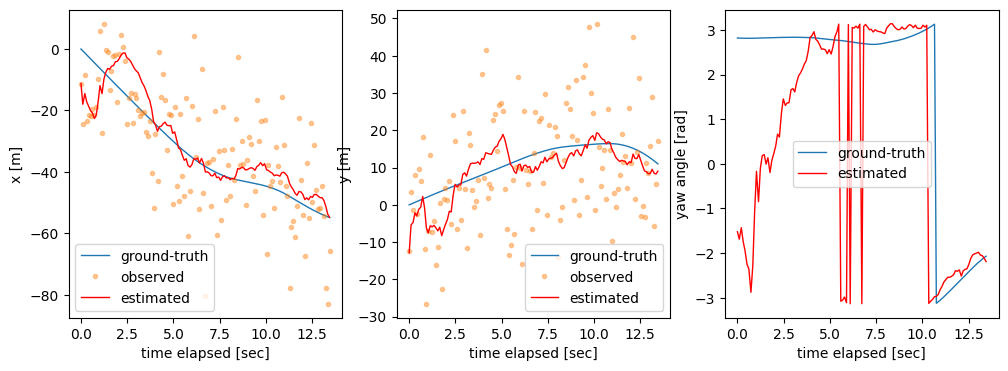

In [28]:
kitti_data.plot_estimated_data(ekf_estimated_state)

In [29]:
kitti_data.evaluate_filter(ekf_estimated_state)

{'RMSE': array([6.69366649, 4.57313531, 1.05247414]),
 'MAE': array([5.07717739, 3.76009262, 0.67803979]),
 'MSE': array([44.80517114, 20.91356659,  1.10770182]),
 'NRMSE': array([0.09387132, 0.0641332 , 0.01475979]),
 'Mean_Error': array([-1.99646653,  1.7165831 ,  0.08333513]),
 'Std_Error': array([6.38899777, 4.23873909, 1.04916971]),
 'Mean_Angular_Error': 0.08333513425822257}

### Unscented Kalman Filter

In [30]:
ukf_estimated_state = apply_estimation_filter(kitti_data, 'UKF', x_0, P_0, R, Q)

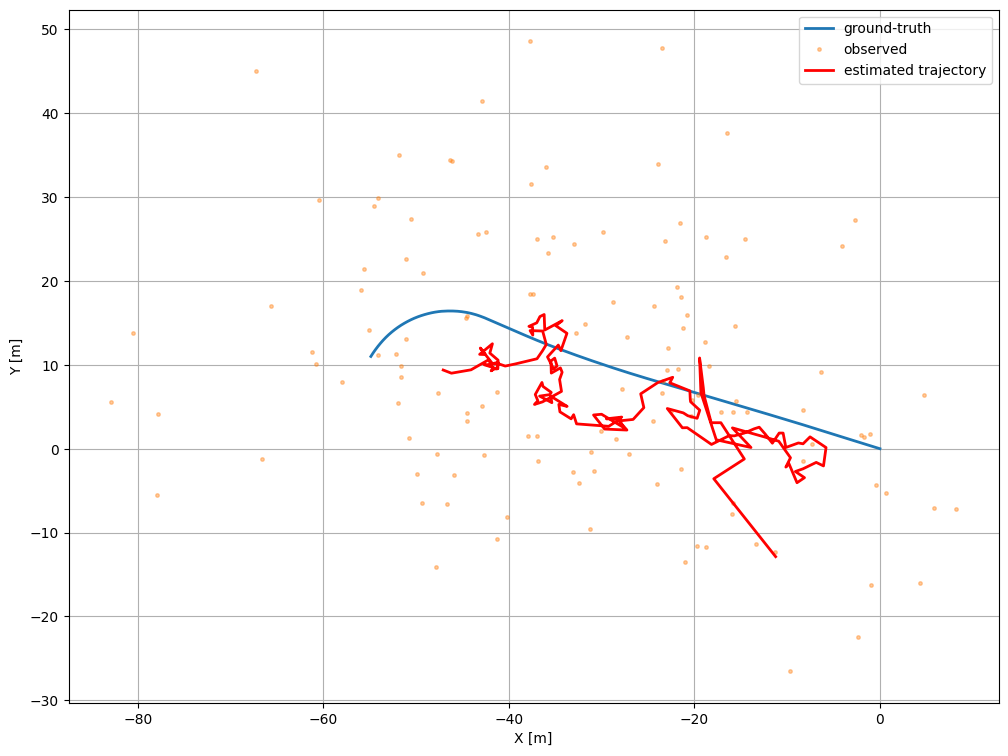

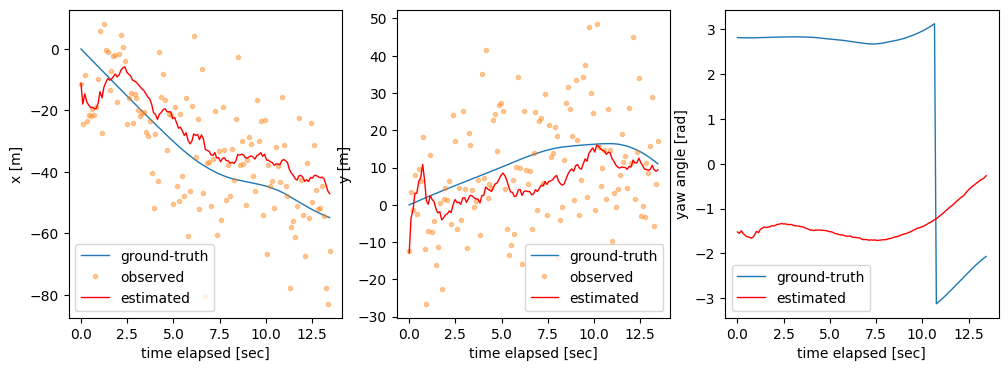

In [31]:
kitti_data.plot_estimated_data(ukf_estimated_state)

In [32]:
kitti_data.evaluate_filter(ukf_estimated_state)

{'RMSE': array([8.36037295, 6.04660899, 1.93632265]),
 'MAE': array([7.78879891, 5.39055694, 1.93469441]),
 'MSE': array([69.89583592, 36.56148026,  3.74934541]),
 'NRMSE': array([0.11724505, 0.08479705, 0.0271548 ]),
 'Mean_Error': array([-5.19650175,  4.93123009, -1.93469441]),
 'Std_Error': array([6.54921411, 3.49920707, 0.07939118]),
 'Mean_Angular_Error': -1.9346944071561025}

### Compare yaw angle

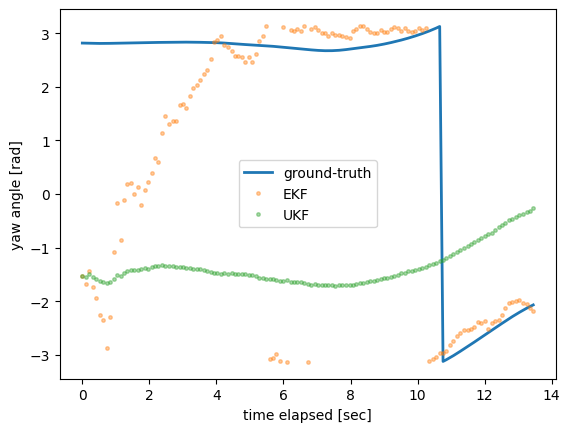

In [33]:
timestamps = kitti_data.timestamps
original_yaw_angle = kitti_data.ground_truth_states[2, :]
ekf_estimated = ekf_estimated_state[2, :]
ukf_estimated = ukf_estimated_state[2, :]

fig = plt.figure()
plt.plot(timestamps, original_yaw_angle, lw=2, label="ground-truth")
plt.plot(timestamps, ekf_estimated, marker='.', lw=0, markersize=5, alpha=0.4, label='EKF')
plt.plot(timestamps, ukf_estimated, marker='.', lw=0, markersize=5, alpha=0.4, label='UKF')
plt.xlabel('time elapsed [sec]')
plt.ylabel('yaw angle [rad]')
plt.legend()
plt.savefig('2011_09_26_0035_02.png', bbox_inches='tight')
#plt.show()

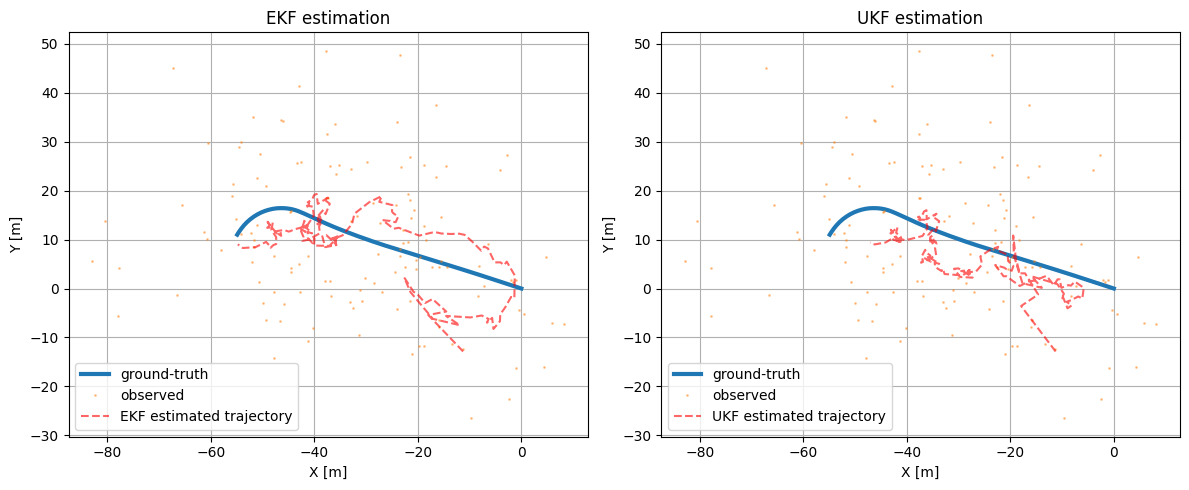

In [34]:
fig, axarr = plt.subplots(1, 2, figsize=(12,5))
ax = axarr[0]
ax.plot(kitti_data.ground_truth_states[0, :], kitti_data.ground_truth_states[1, :], lw=3, label='ground-truth')
ax.plot(kitti_data.observation_states[0, :], kitti_data.observation_states[1, :], lw=0, marker='.', markersize=2, alpha=0.4, label='observed')
ax.plot(ekf_estimated_state[0, :], ekf_estimated_state[1, :], linestyle='dashed', lw=1.5, alpha=0.6, label='EKF estimated trajectory', color='r')
#ax.plot(ukf_estimated_state[0, :], ukf_estimated_state[1, :], linestyle='dashed', lw=1.5, alpha=0.99, label='UKF estimated trajectory', color='g')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
#ax.set_ylim([-70, 55])
#ax.set_xlim([-350, 180])
ax.title.set_text('EKF estimation')
ax.grid()
ax.legend()

ax = axarr[1]
ax.plot(kitti_data.ground_truth_states[0, :], kitti_data.ground_truth_states[1, :], lw=3, label='ground-truth')
ax.plot(kitti_data.observation_states[0, :], kitti_data.observation_states[1, :], lw=0, marker='.', markersize=2, alpha=0.4, label='observed')
#ax.plot(ekf_estimated_state[0, :], ekf_estimated_state[1, :], linestyle='dashed', lw=1.5, alpha=0.99, label='EKF estimated trajectory', color='r')
ax.plot(ukf_estimated_state[0, :], ukf_estimated_state[1, :], linestyle='dashed', lw=1.5, alpha=0.6, label='UKF estimated trajectory', color='r')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
#ax.set_ylim([-70, 55])
#ax.set_xlim([-350, 180])
ax.title.set_text('UKF estimation')
ax.grid()
ax.legend()

plt.tight_layout()
#plt.show()
plt.savefig('2011_09_26_0035_04.png', bbox_inches='tight')